# Combining COS Data from Multiple Lifetime Positions and Central Wavelengths

### <span style="font-weight:normal">In this notebook, we will explore the implications of combining COS data taken at different lifetime positions and central wavelengths.</span>

## Learning Goals: 

In this tutorial, you will learn 

- How the COS line-spread functions (LSFs) vary with central wavelength and lifetime position

- How to smooth one COS spectrum to the resolution of another -- and the limits of this approach 

- How to construct a bespoke line-spread function appropriate for particular combination of spectra


## Table of Contents
**0. [Introduction](#introduction)**

**1. [Download the COS Line-Spread Functions](#lsfdownload)**

**2. [Define Functions for Later Use](#definitions)**

**3. [Compare LSFs from Various Lifetime Positions and CENWAVEs](#comparelsfs)**

\- 3.1 [LSFs from Various Central Wavelenths](#cenwaves)

\- 3.2 [LSFs from Various Lifetime Positions](#lifetimes)

**4. [Techniques for Combining Spectra with Different LSFs](#combining)**

\- 4.1 [Retrieve and Combine the Spectra](#getdata)

\- 4.2 [Fit each combination of grating, LSF, and CENWAVE separately](#separate)

\- 4.3 [Convolve the LP1 Spectrum to Match LP4](#convolve)

\- 4.4 [Construct a bespoke LSF for this spectral combination](#bespoke)

<a id = introduction></a>
## 0. Introduction

The [Hubble Advanced Spectral Products (HASP)](https://archive.stsci.edu/missions-and-data/hst/hasp) program provides co-added spectra within individual observing programs that use the [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) and the [Cosmic Origins Spectrograph (COS)](https://www.stsci.edu/hst/instrumentation/cos) instruments onboard the [Hubble Space Telescope (HST)](https://www.stsci.edu/hst). The [Hubble Spectroscopic Legacy Archive (HSLA)](https://archive.stsci.edu/missions-and-data/hsla), goes one step farther, combining data from multiple instruments and observing programs to create spectra with the highest possible signal-to-noise and wavelength range.

When analyzing any scientific measurement, it is important to consider all of the instrumental effects to which your data are subject.  In the case of imaging, point sources in the sky are broadened by the telescope and instrument optics.  In the case of spectroscopy, narrow absorption lines are broadened by the line-spread function (LSF; the shape imposed on an infinitely narrow line by the optics) of the spectrograph.  In most cases, the LSF of a spectrograph can be approximated by a Gaussian of known FHWM. For COS, the LSF is not a Gaussian; it has more power in the wings than a Gaussian of the same FWHM.  Ignoring this effect could lead one to under-estimate the flux in an emission line or the equivalent width of an absorption feature.  The COS LSF is described in [Section 3.3.1 of the COS Instrument Handbook](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-3-the-cos-line-spread-function#id-3.3TheCOSLineSpreadFunction-Section3.3.13.3.1Non-GaussianityoftheCOSLSF).

A second effect comes into play with both HASP and HSLA: the LSFs of spectra taken in the blue modes (CENWAVES 1055, 1096, and 1222) are considerably broader than those of spectra with CENWAVE 1291 and higher.  For full wavelength coverage, observers are instructed to use both CENWAVE 1222 and CENWAVE 1291.  But in the region where the resulting spectra overlap (from about 1100 to 1350 A), both HASP and HSLA simply co-add the two spectra, resulting in a hybrid LSF that complicates the analysis.

A third effect:  Because the COS detector is susceptible to gain sag, the instrument is adjusted at regular intervals so that spectra fall on previously unilluminated regions of the detector, called lifetime positions (LPs).  Spectra taken at LP1 have the highest spectral resolution, while spectra taken at other LPs have successively lower resolution. The final product of the HSLA, a spectrum made by co-adding data from multiple observing programs, may contain data taken at multiple LPs, again resulting in a hybrid LSF.  These effects are illustrated in [Figure 3.7 of the COS Instrument Handbook](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-3-the-cos-line-spread-function#id-3.3TheCOSLineSpreadFunction-Section3.3.23.3.2QuantifyingtheResolution).

In this notebook, we will compare the COS LSFs from multiple CENWAVEs and lifetime positions to better understand these effects.  Then we will consider three ways to deal with them.  The first is not to use the final HASP and HSLA products at all, but to create products that contain data from a single grating, LP, and CENWAVE and fit them separately.  The second is to combine these single-configuration products into a co-added spectrum, first smoothing the higher-resolution spectra to the resolution of the lowest-resolution spectrum.  The third approach is to use the HASP/HSLA final products, but to scale and combine the relevant LSFs to match your data.

By the way, the G130M and G160M gratings have different LSFs in the region of overlap, so everything in this notebook applies to the case of multiple gratings.  The difference is that neither HASP nor HSLA co-adds data from different instruments or gratings, so the final data products are immune to this effect.

### Imports

We will be using multiple libraries to retrieve and analyze data: 
* `astropy.units` to assign units to various quantities
* `astropy.convolution.convolve` to convolve functions with a Gaussian
* `astropy.io.ascii` and `fits` to work with ASCII and FITS files
* `astropy.visualization.quantity_support` to put units on our plots
* `astroquery.mast.Observations` to retrieve COS spectra from MAST
* `glob` to work with multiple files in our directories
* `matplotlib.pyplot` to plot spectra
* `numpy` to calculate various values
* `os` to interact with the operating system
* `pathlib.Path` to create a data directory 
* `scipy.optimize.curve_fit` to fit a function to a spectrum
* `shutil` to perform directory and file operations
* `specutils.Spectrum1d` to create Spectrum1d objects

We recommend creating a HASP-specific `conda` environment. You can check out our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook to create such an environment. 

Let's import all of the packages that we will use in this notebook by running the next cell:

In [1]:
%matplotlib inline

import glob
import matplotlib
import numpy as np
import os
import shutil
import urllib

from astropy.convolution import convolve
from astropy.io import ascii, fits
from astropy.visualization import quantity_support
from astroquery.mast import Observations
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit

# Specify plot parameters.
quantity_support()  # to put units on the axes below 
matplotlib.rcParams['figure.figsize'] = [15, 5]

<a id = lsfdownload></a>
## 1. Download the COS Line-Spread Functions

From the [COS homepage](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution), you can find all the [COS Line Spread Functions](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution).  They are all located in tables containing the various LSFs entitled "Tabulated Theoretical Line Spread Functions" for each individual lifetime position. We will use Python to create a directory to store the LSFs we need, and then download the following LSF files: 

- The LSFs for grating G130M across all lifetime positions (1-5) for central wavelength 1291
- The LSFs for grating G130M for LP2 and central wavelengths 1055, 1096, 1222, and 1327
- The LSF for G130M for LP4 and central wavelength 1309


In [2]:
# Define the LSF directory to hold the files.
lsf_dir = Path("./LSF/")

# If the directory doesn't exist, then create it.
lsf_dir.mkdir(exist_ok=True)

In [3]:
# Create a function that downloads the LSF files we need based on grating, lifetime position, and cenwave. 

def fetch_files(grating, lpPos, cenwave):
    # Link to where all the files live
    COS_site_rootname = (
        "https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/"
        "performance/spectral-resolution/_documents/")
    
    LSF_file_name = f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat"
    
    LSF_file_webpath = COS_site_rootname + LSF_file_name  # Where to find file online
    urllib.request.urlretrieve(
        LSF_file_webpath, str(lsf_dir / LSF_file_name)
    )  # Where to save file to locally
    print(f"Downloaded LSF file to {str(lsf_dir/ LSF_file_name)}")
    

In [4]:
# Use this function to download the LSF files 
# LSFs for grating G130M and central wavelength 1291, across all lifetime positions (1-5)
fetch_files('G130M', '1', '1291')
fetch_files('G130M', '2', '1291')
fetch_files('G130M', '3', '1291')
fetch_files('G130M', '4', '1291')
fetch_files('G130M', '5', '1291')

# LSFs for G130M LP2 central wavelengths 1055, 1096, 1222, and 1327
fetch_files('G130M', '2', '1055')
fetch_files('G130M', '2', '1096')
fetch_files('G130M', '2', '1222')
fetch_files('G130M', '2', '1327')

# LSFs for G130M LP1/LP4 central wavelength 1309
fetch_files('G130M', '1', '1309')
fetch_files('G130M', '4', '1309')


Downloaded LSF file to LSF/aa_LSFTable_G130M_1291_LP1_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1291_LP2_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1291_LP3_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1291_LP4_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1291_LP5_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1055_LP2_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1096_LP2_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1222_LP2_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1327_LP2_cn.dat
Downloaded LSF file to LSF/aa_LSFTable_G130M_1309_LP4_cn.dat


<a id = definitions></a>
## 2. Define Functions for Later Use
Here we define a handful of functions that we will use later.

In [5]:
# Function to compute emperical FWHM of a LSF

def get_fwhm(x, y):
    xprime = np.arange(x.size * 10.) / 10.
    yprime = np.interp(xprime, x, y)
    center = np.argmax(yprime)
    
    half = np.max(y) / 2.
    diff = abs(yprime - half)
    x1 = np.argmin(diff[:center])
    x2 = np.argmin(diff[center:]) + center
    return (x2 - x1)/10

In [6]:
# Function to compute a Gaussian given the value of sigma

def get_gaussian(sigma):
    length = int(8 * sigma)
    # Kernel length must be odd.
    if (length % 2 == 0):
        length += 1
    xx = np.arange(length)
    mu = int(length / 2)
    x = (xx - mu)/sigma
    return np.exp(-0.5 * x**2)

In [7]:
# Function to read an LSF file

def get_lsf(filename, wave):
    table = ascii.read(filename, format='basic')
    lsf = table[str(wave)]
    x = np.arange(lsf.size)

    fwhm = get_fwhm(x, lsf)
    d130 = 0.01
    resolution = wave / fwhm / d130

    return lsf, resolution, fwhm

In [8]:
# Define an LSF object, which we will use when convolving an LSF with a Gaussian.

class LSF(object):
    def __init__(self):
        self.lsf = []

    def add_lsf(self, wave, lsf):
        self.wave = wave
        self.lsf = lsf

    def my_func(self, data_wave, sigma):
        """
        This function convolves a line-spread function with a Gaussian of a given width (sigma).
        """     
        gauss = get_gaussian(sigma)              # Compute Gaussian in LP1 pixels.
        a = convolve(self.lsf, gauss)            # Convolve LP1 LSF with Gaussian.
        return a/np.sum(a)                       # Normalize new LSF.

<a id = comparelsfs></a>
## 3. Compare LSFs from Various Lifetime Positions and CENWAVEs

<a id = cenwaves></a>
### 3.1 LSFs from Various Central Wavelenths

First, let's see how much the LSF changes from one CENWAVE to another.  We'll start at 1200 A, then move to 1350 A.

CENWAVE Res  FWHM (pix)     
1055    2524 47.3
1096    4092 29.2
1222    14082 8.5
1291    14385 8.3
1327    14421 8.3


(120.0, 200.0)

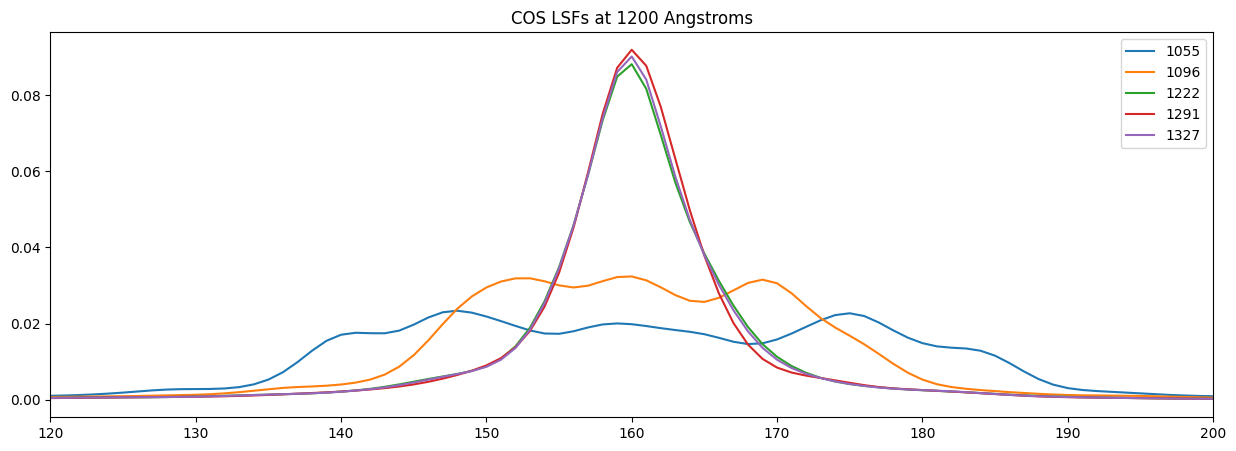

In [9]:
# Read LSF file for G130M, LP2, cenwave = 1222, lambda = 1194

lsf_1055, res_1055, fwhm_1055 = get_lsf('LSF/aa_LSFTable_G130M_1055_LP2_cn.dat', 1194)

# Read LSF file for G130M, LP2, cenwave = 1222, lambda = 1195

lsf_1096, res_1096, fwhm_1096 = get_lsf('LSF/aa_LSFTable_G130M_1096_LP2_cn.dat', 1195)

# Read LSF file for G130M, LP2, cenwave = 1222, lambda = 1197

lsf_1222, res_1222, fwhm_1222 = get_lsf('LSF/aa_LSFTable_G130M_1222_LP2_cn.dat', 1197)

# Read LSF file for G130M, LP2, cenwave = 1291, lambda = 1194

lsf_1291, res_1291, fwhm_1291 = get_lsf('LSF/aa_LSFTable_G130M_1291_LP2_cn.dat', 1194)

# Read LSF files for G130M, LP2, cenwave = 1327, lambda = 1197

lsf_1327, res_1327, fwhm_1327 = get_lsf('LSF/aa_LSFTable_G130M_1327_LP2_cn.dat', 1197)

x = np.arange(lsf_1291.size)

print('CENWAVE Res  FWHM (pix)     ')
print('1055   ', int(res_1055), fwhm_1055)
print('1096   ', int(res_1096), fwhm_1096)
print('1222   ', int(res_1222), fwhm_1222)
print('1291   ', int(res_1291), fwhm_1291)
print('1327   ', int(res_1327), fwhm_1327)

f, ax = plt.subplots() 
plt.plot(x, lsf_1055, label='1055')
plt.plot(x, lsf_1096, label='1096')
plt.plot(x, lsf_1222, label='1222')
plt.plot(x, lsf_1291, label='1291')
plt.plot(x, lsf_1327, label='1327')
plt.title('COS LSFs at 1200 Angstroms')
ax.legend()
ax.set_xlim([120, 200])

1200 A represents the red end of the CENWAVE 1055 and 1096 spectra.  In this region, their LSFs are completely different from those of the bluer modes.  This matters because HASP and HSLA co-add spectra with all available CENWAVEs.  At wavelengths where the LSFs differ, spectral lines in the combined spectra could have unexpected shapes.

CENWAVE Res  FWHM (pix)     
1222    9013 15.0
1291    17532 7.7
1327    17320 7.8


(140.0, 180.0)

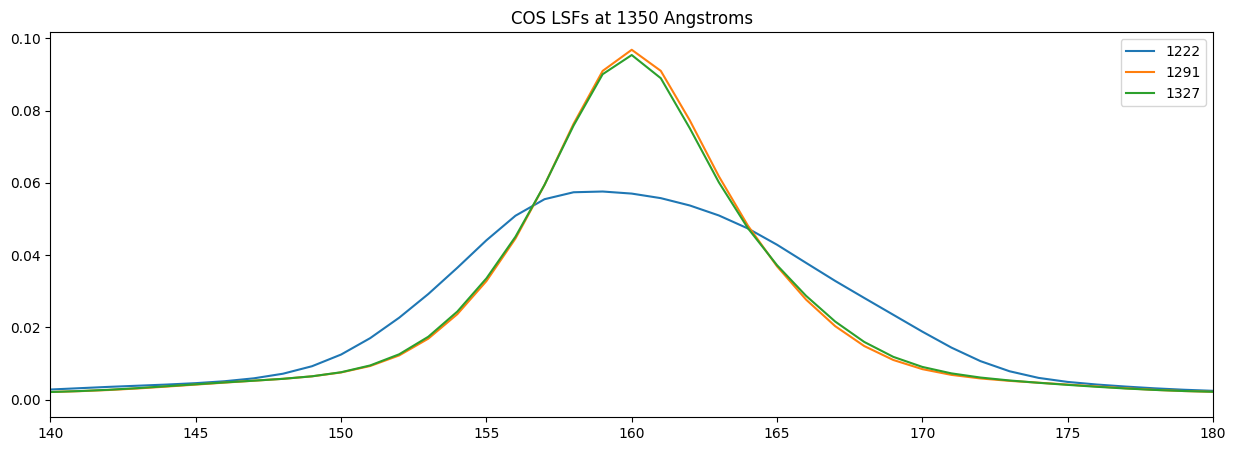

In [10]:
# Read LSF file for G130M, LP2, cenwave = 1222, lambda = 1352

lsf_1222, res_1222, fwhm_1222 = get_lsf('LSF/aa_LSFTable_G130M_1222_LP2_cn.dat', 1352)

# Read LSF file for G130M, LP2, cenwave = 1291, lambda = 1350

lsf_1291, res_1291, fwhm_1291 = get_lsf('LSF/aa_LSFTable_G130M_1291_LP2_cn.dat', 1350)

# Read LSF files for G130M, LP2, cenwave = 1327, lambda = 1351

lsf_1327, res_1327, fwhm_1327 = get_lsf('LSF/aa_LSFTable_G130M_1327_LP2_cn.dat', 1351)

x = np.arange(lsf_1291.size)

print('CENWAVE Res  FWHM (pix)     ')
print('1222   ', int(res_1222), fwhm_1222)
print('1291   ', int(res_1291), fwhm_1291)
print('1327   ', int(res_1327), fwhm_1327)

f, ax = plt.subplots() 
plt.plot(x, lsf_1222, label='1222')
plt.plot(x, lsf_1291, label='1291')
plt.plot(x, lsf_1327, label='1327')
plt.title('COS LSFs at 1350 Angstroms')
ax.legend()
ax.set_xlim([140, 180])

At 1350 A, we are at the red end of the CENWAVE 1222 spectrum.  Again, its LSF is much broader than those of the redder CENWAVEs.  If you need the highest possible spectral resolution, then you don't want to co-add spectra taken in the blue modes (CENWAVE 1055, 1096, or 1222) with those taken in the standard modes (CENWAVE >= 1291).

Which CENWAVEs contribute to the final HASP/HSLA spectrum?  Information about the CENWAVE is lost early in HASP processing.  It is not included in the HSLA metadata files.  The metadata files do list the minimum wavelength contributed by each grating/LP combination; values smaller than 1400 A indicate that at least one of the input spectra has CENWAVE <= 1222.

<a id = lifetimes></a>
### 3.2 LSFs from Various Lifetime Positions

The COS LSF varies with lifetime position as well as with CENWAVE.  To explore this effect, we read the LSFs for lifetime positions 1 through 5, compute their resolution and FWHM, and plot them.

LP  Res  FWHM (pixels)
1   19117 6.8
2   16666 7.8
3   16883 7.7
4   14772 8.8
5   15476 8.4


(140.0, 180.0)

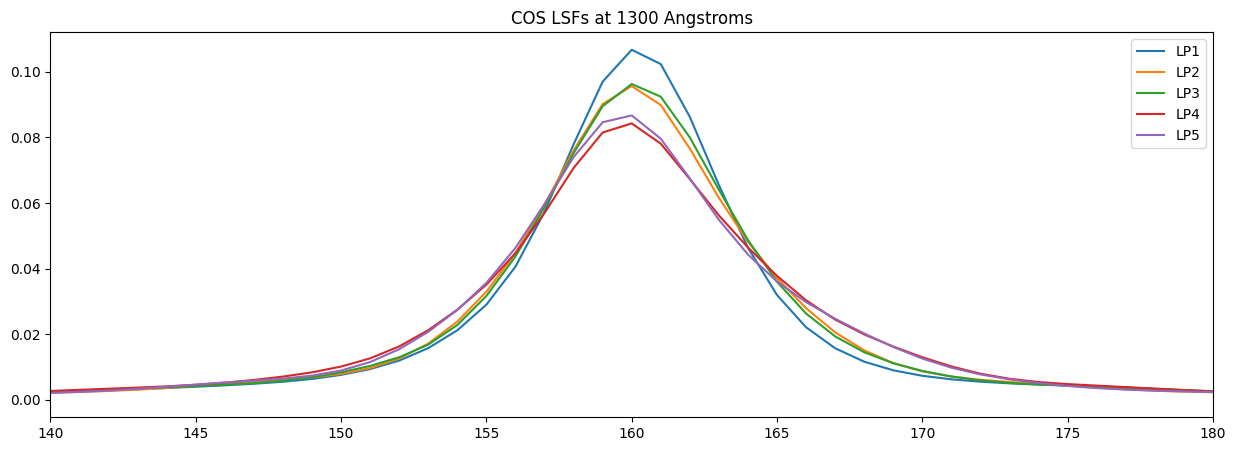

In [11]:
# Read LSF files for G130M, cenwave = 1291, lambda = 1300

lsf_lp1, res_lp1, fwhm_lp1 = get_lsf('LSF/aa_LSFTable_G130M_1291_LP1_cn.dat', 1300)
lsf_lp2, res_lp2, fwhm_lp2 = get_lsf('LSF/aa_LSFTable_G130M_1291_LP2_cn.dat', 1300)
lsf_lp3, res_lp3, fwhm_lp3 = get_lsf('LSF/aa_LSFTable_G130M_1291_LP3_cn.dat', 1300)
lsf_lp4, res_lp4, fwhm_lp4 = get_lsf('LSF/aa_LSFTable_G130M_1291_LP4_cn.dat', 1300)
lsf_lp5, res_lp5, fwhm_lp5 = get_lsf('LSF/aa_LSFTable_G130M_1291_LP5_cn.dat', 1300)

print('LP  Res  FWHM (pixels)')
print('1  ', int(res_lp1), fwhm_lp1)
print('2  ', int(res_lp2), fwhm_lp2)
print('3  ', int(res_lp3), fwhm_lp3)
print('4  ', int(res_lp4), fwhm_lp4)
print('5  ', int(res_lp5), fwhm_lp5)

f, ax = plt.subplots() 
x = np.arange(lsf_lp1.size)
plt.plot(x, lsf_lp1, label='LP1')
plt.plot(x, lsf_lp2, label='LP2')
plt.plot(x, lsf_lp3, label='LP3')
plt.plot(x, lsf_lp4, label='LP4')
plt.plot(x, lsf_lp5, label='LP5')
plt.title('COS LSFs at 1300 Angstroms')
ax.legend()
ax.set_xlim([140, 180])

We see that there are three families of LSF curves, corresponding to their distance from LP1.  LP1 itself has the highest resolution.  LP2 and LP3, which lie immediately above and below LP1 on the COS detector, have slightly lower resolution.  LP4 and LP5, which are still farther from LP1, have the lowest resolution.

While the peaks of these curves shift to the left with increasing LP number, all five have the same mean value.  This is because, as the curves broaden, more of the flux moves into the wings on the right-hand side of the distribution.

If your science requires that you understand the subtleties of the instrumental line-spread function, then you should proceed carefully when combining data taken at multiple lifetime positions.  We consider two techniques for doing this below.

<a id = combining></a>
## 4. Techniques for Combining Spectra with Different LSFs

<a id = getdata></a>
### 4.1 Retrieve and Combine the Spectra
The star WD0308-565 (WG 7) is a calibration standard.  Let's use spectra taken at two lifetime positions.  For maximum contrast, we will use LP1 and LP4.  
We begin by setting up our directory structure and querying the MAST database for all COS spectra of the star. This will give us a list of all observations for the program.

In [12]:
# Define the data-download directory.
cos_data_dir = Path("./cos_data/")
# Define the products directory to hold the output.
cos_products_dir = Path("./cos_products/")

# If the directories doesn't exist, then create them.
cos_data_dir.mkdir(exist_ok=True)
cos_products_dir.mkdir(exist_ok=True)

In [13]:
# Conduct the query
wg7_products = Observations.get_product_list(
    Observations.query_criteria(
        instrument_name='COS',
        target_name='WD*0308-565',
        dataproduct_type="SPECTRUM"
    )
)

This query returns all available data, but we want only the x1d files of spectra taken with the G130M grating.  (This takes a few minutes, so be patient.)

In [14]:
Observations.download_products(
    wg7_products,
    download_dir=str(cos_data_dir),
    filters='G130M',
    productSubGroupDescription=["X1D"]
)

INFO: Found cached file cos_data/mastDownload/HST/lbnm02a2q/lbnm02a2q_x1d.fits with expected size 3389760. [astroquery.query]
INFO: Found cached file cos_data/mastDownload/HST/lbnm02a4q/lbnm02a4q_x1d.fits with expected size 3389760. [astroquery.query]
INFO: Found cached file cos_data/mastDownload/HST/lbnm02a6q/lbnm02a6q_x1d.fits with expected size 3389760. [astroquery.query]
INFO: Found cached file cos_data/mastDownload/HST/lbnm02arq/lbnm02arq_x1d.fits with expected size 3389760. [astroquery.query]
INFO: Found cached file cos_data/mastDownload/HST/lbnm02auq/lbnm02auq_x1d.fits with expected size 3389760. [astroquery.query]
INFO: Found cached file cos_data/mastDownload/HST/lbnm02awq/lbnm02awq_x1d.fits with expected size 3389760. [astroquery.query]
INFO: Found cached file cos_data/mastDownload/HST/lbnm02ayq/lbnm02ayq_x1d.fits with expected size 3389760. [astroquery.query]
INFO: Found cached file cos_data/mastDownload/HST/lbnm02b0q/lbnm02b0q_x1d.fits with expected size 3389760. [astroquery

Local Path,Status,Message,URL
str54,str8,object,object
cos_data/mastDownload/HST/lbnm02a2q/lbnm02a2q_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02a4q/lbnm02a4q_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02a6q/lbnm02a6q_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02arq/lbnm02arq_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02auq/lbnm02auq_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02awq/lbnm02awq_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02ayq/lbnm02ayq_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02b0q/lbnm02b0q_x1d.fits,COMPLETE,None,None
cos_data/mastDownload/HST/lbnm02b2q/lbnm02b2q_x1d.fits,COMPLETE,None,None


When we download data using astroquery, it creates a directory called mastDownload/HST. Each dataset goes into a separate subfolder within that directory.  Before running the combination script, we must move all of the x1d files into a single directory. 

In [ ]:
# The path to all obs_id folders
mast_path = f"{cos_data_dir}/mastDownload/HST/"

# Check if mastDownload exists
if not os.path.exists(mast_path):
    print(f"Directory {mast_path} doesn't exist.")

# Getting a list of all obs_id folders. Each folder contains the FITS files
obs_id_dirs = os.listdir(mast_path)

# Iterating through sub-folders to change the path of each FITS file
for obs_id in obs_id_dirs:
    # This is the path to each obs_id folder
    obs_id_path = os.path.join(mast_path, obs_id)

    # Getting list of FITS files in /mastDownload/HST/<obs_id> folder
    cos_files = glob.glob(obs_id_path + "/*fits")

    # Iterating through each of these files to change their path individually
    # We will be moving them to /cos_data
    for file in cos_files:
        file_path = Path(file)
        new_path = cos_data_dir / file_path.name
        shutil.move(file, new_path)

# Now we can remove the mastDownload directory
if os.path.exists(mast_path):
    shutil.rmtree(f"{cos_data_dir}/mastDownload/")


We want only the files taken at lifetime positions 1 and 4 and with CENWAVE > 1250, so delete everything else.

In [ ]:
cos_files = glob.glob('./cos_data/*fits')

for file in cos_files:
    hdr = fits.getheader(file)
    cenwave = hdr['CENWAVE']
    life_adj = hdr['LIFE_ADJ']

    if (cenwave < 1250):
        os.remove(file)
        continue
        
    if not ((life_adj == 1) or (life_adj == 4)):
        os.remove(file)

Now that we’ve retrieved and filtered the spectra, we can run the co-add script.

In a terminal window, execute the following command (or run the cell below). 

`swrapper -i cos_data -o cos_products -x`

The -i parameter is the input directory (i.e, where the FITS files are located), while -o indicates the directory that will contain the newly created co-added products.  -x tells the program to keep the intermediate products.

Make sure that you are in the hasp-env conda environment that we created at the beginning of the notebook.

In [ ]:
! swrapper -i cos_data -o cos_products -x

In [ ]:
# Read the combined spectra for each lifetime position.

tbdata = fits.getdata('cos_products/hst_cos_cos-data_g130m_lp01_cspec.fits')
lp1_wave = tbdata['wavelength'][0]
lp1_flux = tbdata['flux'][0]
lp1_exp = tbdata['eff_exptime'][0]

tbdata = fits.getdata('cos_products/hst_cos_cos-data_g130m_lp04_cspec.fits')
lp4_wave = tbdata['wavelength'][0]
lp4_flux = tbdata['flux'][0]
lp4_exp = tbdata['eff_exptime'][0]

In [ ]:
# Plot the spectra.

f, ax = plt.subplots()
ax.plot(lp1_wave, lp1_flux, label='LP1') 
ax.plot(lp4_wave, lp4_flux, label='LP4') 
ax.legend()
ax.set_xlim(1333, 1338)
ax.set_ylim([0, 3e-13])
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax.set_ylabel('Flux (erg cm$^{-2}$ s$^{-1}$ $\mathrm{\AA}^{-1}$)')

<a id = separate></a>
### 4.2 Fit each combination of grating, LSF, and CENWAVE separately
When dealing with spectra obtained using multiple instrument configurations, the most accurate results are produced, not by summing the spectra to maximize the S/N ratio, but by fitting each spectrum separately, using the LSF appropriate for that configuration.  In this example, we could either fit our models to the LP1 and LP4 spectra separately and average the results or tweak our code to fit the two spectra simultaneously.  In either case, we would use the LSF for CENWAVE 1339 (the average CENWAVE for the red modes) and the appropriate lifetime position.

<a id = convolve></a>
### 4.3 Convolve the LP1 Spectrum to Match LP4
Another approach is to reduce the resolution of the LP1 spectrum to match that of the LP4 spectrum.  We use the LSFs of the two spectra to derive a Gaussian that converts the LSF for LP1 into that for LP2, then convolve the LP1 spectrum with this Gaussian.

In [ ]:
# We are interested in lines near 1335 A, so let's read the corresponding LSFs.

lsf_lp1, res_lp1, fwhm_lp1 = get_lsf('LSF/aa_LSFTable_G130M_1309_LP1_cn.dat', 1333)
lsf_lp4, res_lp4, fwhm_lp4 = get_lsf('LSF/aa_LSFTable_G130M_1309_LP4_cn.dat', 1333)
lsf_wave = 0.01 * (np.arange(321) - 160)

f, ax = plt.subplots()
ax.plot(lsf_wave, lsf_lp1, label='LP1') 
ax.plot(lsf_wave, lsf_lp4, label='LP4') 
ax.legend()
ax.set_xlim(-0.3, 0.3)

In [ ]:
# Construct an LSF object to hold the LP1 LSF,  Then find the Gaussian that, 
# when convolved with the LP1 LSF, best reproduces LP4.

s = LSF()
s.add_lsf(lsf_wave, lsf_lp1)

p0 = [1.]
popt, pcov = curve_fit(s.my_func, lsf_wave, lsf_lp4, p0=p0)
sigma = popt[0]
convolution = s.my_func(lsf_wave, sigma)
print('sigma = ', sigma)

In [ ]:
# In this plot, the curve labeled "Convolution" is the LP1 LSF convolved with a Gaussian to reproduce the LP4 LSF.

f, ax = plt.subplots()
ax.plot(lsf_wave, lsf_lp1, label='LP1') 
ax.plot(lsf_wave, lsf_lp4, label='LP4') 
ax.plot(lsf_wave, convolution, label='Convolution')
ax.legend()
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax.set_xlim(-0.3, 0.3)

In [ ]:
# Plot the residuals.

res = lsf_lp4 - convolution

f, ax = plt.subplots() 
plt.plot(lsf_wave, res)
ax.set_xlim([-0.3, 0.3])
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
r1 = res

# The largest deviation is about 8%.
# It may be possible to devise a kernel that does a better job, but this is fine for now.

In [ ]:
# Now convolve the LP1 spectrum with our best-fit Gaussian.
   
gauss = get_gaussian(sigma)
out = convolve(lp1_flux, gauss)

# Plot the smoothed LP1 spectrum and the LP4 spectrum.

f, ax = plt.subplots() 
plt.plot(lp1_wave, out, label='Smoothed LP1')
plt.plot(lp4_wave, lp4_flux, label='LP4')
ax.legend()
ax.set_xlim(1333, 1338)
ax.set_ylim([0, 3e-13])
ax.set_ylabel('Flux ($10^{-13}$ erg cm$^{-2}$ s$^{-1}$ $\mathrm{\AA}^{-1}$)')
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')

The good thing about this approach is that, in the region of overlap, the tabulated LP4 LSF functions can be used without modification.  The bad thing is that convolution by a Gaussian this broad smooths the data to an unacceptable degree.  Also, when the data are smoothed, the pixel values are no longer independent, and the errors are correlated.  Given these problems, this approach is not recommended.

<a id = bespoke></a>
### 4.4 Construct a bespoke LSF for this spectral combination
The third option is to sum the two spectra and construct a new LSF to match.  We already have the summed spectrum.  It is the final product of the coadd script.  
Note that this spectrum contains only LP1 and LP4 data taken in the standard modes (CENWAVE > 1250 A).  A spectrum retrieved from MAST would contain data from all lifetime positions and central wavelengths.

In [ ]:
tbdata = fits.getdata('cos_products/hst_cos-data_aspec.fits')
combo_wave = tbdata['wavelength'][0]
combo_flux = tbdata['flux'][0]

In [ ]:
# Determine the exposure times for each lifetime position.

lp1_exptime = np.mean(lp1_exp[np.where((lp1_wave > 1333) & (lp1_wave < 1338))])
lp4_exptime = np.mean(lp4_exp[np.where((lp4_wave > 1333) & (lp4_wave < 1338))])
print('LP1 exposure time:', lp1_exptime)
print('LP4 exposure time:', lp4_exptime)

In [ ]:
# Plot the individual and combined spectra.

f, ax = plt.subplots()  
ax.plot(combo_wave, combo_flux, label='Combo') 
ax.plot(lp1_wave, lp1_flux, label='LP1') 
ax.plot(lp4_wave, lp4_flux, label='LP4') 
ax.set_xlim(1333, 1338)
ax.set_ylim([0, 3e-13])
ax.set_ylabel('Flux ($10^{-13}$ erg cm$^{-2}$ s$^{-1}$ $\mathrm{\AA}^{-1}$)')
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
ax.legend()

In this case, the exposure time of the LP4 spectrum is four times that of the LP1 spectrum, so the combined spectrum looks a lot like the (lower-resolution) LP4 spectrum, but you get the idea.

This approach maintains the full resolution of the LP1 spectrum and the statistical independence of each pixel.  To construct an LSF for the combined spectrum, we scale and combine the LSFs, weighting by the exposure time.

In [ ]:
lsf_combo = (lsf_lp1 * lp1_exptime + lsf_lp4 * lp4_exptime) / (lp1_exptime + lp4_exptime)

f, ax = plt.subplots() 
plt.plot(lsf_wave, lsf_lp1, label='LP1')
plt.plot(lsf_wave, lsf_lp4, label='LP4')
plt.plot(lsf_wave, lsf_combo, label='Combo')
ax.legend()
ax.set_xlim([-0.3, 0.3])
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')

If you have a synthetic spectrum, you can convolve it with the combined LSF to reproduce the features in the combined spectrum.  Of course, this LSF is valid only for the region around 1335 A.  You must construct separate LSFs for each spectral feature.

# Congrats on completing the notebook!

### There are more tutorial notebooks in [this notebooks repo](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP).  Check them out!

## About this Notebook
**Authors:** Van Dixon (dixon@stsci.edu)

**Editor:** Anna Payne (apayne@stsci.edu

**Updated on:** May 2025 

*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*


## Citations

If you use `astropy`, `astroquery`, `numpy`, or `matplotlib`, for published research, please cite the authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)

* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)

* [Citing `numpy`](https://numpy.org/citing-numpy/)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>